<a href="https://colab.research.google.com/github/umabhargavi20/ComputerVision/blob/main/CVProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#This portion of code is to mount the file to the drive. Feel free to ignore this if not needed
#'''
from google.colab import drive
drive.mount('/content/drive')
import os
#os.chdir('/content/drive/My Drive/CVPROJECT')
os.chdir('/content/drive/MyDrive/')
#'''


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the libraries**

In [ ]:
# Import library modules
import sys
import cv2 # OpenCV library
from PIL import Image  # Python Imaging Library
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from math import acos, degrees

# (Note: we would use cv2.imshow if running on your laptop;
#  cv2.imshow is not allowed in Colab, so use cv2_imshow instead)
from google.colab.patches import cv2_imshow

**1.Reading the image (Enter the image here)**

In [ ]:
  #Enter the file name here (Run all cells to see output)
  filename = "CV project/clock2_04.jpg"

  im0in = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  #We use cv2.Canny to get the edges of the image.
  #This is to make sure we can accurately extract the lines
  edge_im = cv2.Canny(im0in, 75, 225)
  #cv2_imshow(edge_im)

  #print("rows:",im0in.shape[0],"columns:",im0in.shape[1])

  #The x and y coordinates of the edges are retrieved from the canny image
  edge_y, edge_x = np.nonzero(edge_im)

  #This is maximum value d can be for the parameter space
  #implicit representation with polar coordinates is used
  shortest_dim = im0in.shape[0]
  if im0in.shape[0] > im0in.shape[1]:
    shortest_dim = im0in.shape[1]
  max_d = int(np.hypot(im0in.shape[0],im0in.shape[1]))
  #The parameter space is constructed
  param_space = np.zeros((max_d,180))
  theta_range = np.arange(0,180)
  #this is to keep track which coordinate correspond to which line detected
  edge_points = {d: {t: [] for t in range(180)} for d in range(-max_d, max_d)}

**2.Hough Transform**

In [ ]:
  for i in range(len(edge_x)):
    for t in theta_range:
      #the d values for each theta and point is calculated
      d = int(edge_x[i] * np.cos(np.radians(t)) + edge_y[i] * np.sin(np.radians(t)))
      #the voting for the coordinate in parameter space is done
      param_space[d,t] += 1
      #simultaneously, the point is added to the list of coordinates for the parameter space
      edge_points[d][t].append((edge_x[i], edge_y[i]))


**3.Extracting longest lines**

In [ ]:
  d_vals, theta_vals = np.nonzero(param_space > 0.15*shortest_dim)
  '''
  for dvals, theta_v in zip(d_vals, theta_vals):
    #print(len(edge_points[dvals][theta_v]))
    for i in range(len(edge_points[dvals][theta_v])):
      plt.plot(edge_points[dvals][theta_v][i][0], edge_points[dvals][theta_v][i][1], marker='o', markersize=1, c="red")
  plt.imshow(im0in, cmap='gray')
  '''
  #print(d_vals)
  #print(theta_vals)
  #This section can show where points are detected along lines
  filt_points = []
  index = 0
  for dval, theta in zip(d_vals, theta_vals):
    #this is the longest list of consecutive points found
    points = []
    #this is a list of consecutive points that becomes empty again if there is a disconnect
    if len(edge_points[dval][theta]) < 0.1*shortest_dim:
      continue
    this_points = [(edge_points[dval][theta][0][0], edge_points[dval][theta][0][1])]
    consec_count = 0
    for i in range(1,len(edge_points[dval][theta])):
      #if the point is close to the previous consecutive point then it is added to the current list of consecutive points
      if (np.linalg.norm(np.array(this_points[len(this_points)-1]) - np.array((edge_points[dval][theta][i][0], edge_points[dval][theta][i][1]))) < 20):
        this_points.append((edge_points[dval][theta][i][0], edge_points[dval][theta][i][1]))
        consec_count += 1
      #if a disconnect was found different actions could happen
      else:
        #if this new list of consecutive points is the longest, then it is named the longest line (longest list of consecutive points)
        #the current consecutive points lists restarts as well
        if (consec_count > len(points)):
          consec_count = 0
          points = this_points.copy()
          this_points.clear()
          this_points.append((edge_points[dval][theta][i][0], edge_points[dval][theta][i][1]))
        #otherwise, just the current consecutive points list restarts
        else:
          consec_count = 0
          this_points.clear()
          this_points.append((edge_points[dval][theta][i][0], edge_points[dval][theta][i][1]))
    filt_points.append(points)
'''
  for l in filt_points:
    for pt in l:
      plt.plot(pt[0], pt[1], marker='o', markersize=1, c="red")
  plt.imshow(im0in, cmap='gray')
  '''

'\nfor l in filt_points:\n  for pt in l:\n    plt.plot(pt[0], pt[1], marker=\'o\', markersize=1, c="red")\nplt.imshow(im0in, cmap=\'gray\')\n'

**4.Filtering lines based on proximity to the center**


In [ ]:
  #This is assuming that the clock center is at the center of the image
  close_c = []
  for line in filt_points:
    for p in line:
      if math.sqrt(math.pow(im0in.shape[1]/2 - p[0], 2) + math.pow(im0in.shape[0]/2 - p[1], 2)) < 0.15*shortest_dim:
        close_c.append(line)
        break

**5. Displaying lines and extracting angle-length pairs**

In [ ]:
  lines_pairs = []
  for l in close_c:
    p1 = l[0]
    p2 = l[len(l)-1]
    #The goal is to have p1 be the closer point to the center, if they are not then swap p1 and p2
    if math.sqrt(math.pow(im0in.shape[1]/2 - p1[0], 2) + math.pow(im0in.shape[0]/2 - p1[1], 2)) > math.sqrt(math.pow(im0in.shape[1]/2 - p2[0], 2) + math.pow(im0in.shape[0]/2 - p2[1], 2)):
      temp = p2
      p2 = p1
      p1 = temp
    angle = np.degrees(math.atan2(p2[0] - p1[0], p1[1] - p2[1]))
    if angle < 0:
      angle += 360
    length = math.sqrt(math.pow(p1[0] - p2[0], 2) + math.pow(p1[1] - p2[1], 2))
    #The length of the line and the angle it is at are paired and added to the list
    lines_pairs.append((angle, length))


**6.Sorting lines based on angle and clustering**

In [ ]:
  #The source for the clustering and summarizing: https://blog.jinay.dev/posts/timekeeper/
  lines_pairs.sort()  # sorts by angle
  #print(lines_pairs)
  max_angle_gap = 5
  clusters = [[lines_pairs[0]]]
  for i in range(1, len(lines_pairs)):
    if abs(lines_pairs[i][0] - lines_pairs[i-1][0]) <= max_angle_gap:
      clusters[len(clusters) - 1].append(lines_pairs[i])
    else:
      clusters.append([lines_pairs[i]])

**7. Summarizing clusters and extracting relevant lines**

In [ ]:
  summary = []
  for cluster in clusters:
    angles = np.array([angle for angle, length in cluster])
    lengths = np.array([length for angle, length in cluster])
    avg_angle = np.mean(angles)
    max_len = np.max(lengths)
    summary.append((max_len, avg_angle))
    summary.sort(reverse=True)

**8.Convert the summarized lines detected to minutes and hours**

In [ ]:
  hour_ratio = summary[1][1] / 360.
  minute_ratio = summary[0][1] / 360.
  hours = hour_ratio * 12
  minutes = int(round(minute_ratio * 60)) % 60
  margin = 5
  if abs(minutes - 60) < 5 or minutes < 5 or (abs(hours-math.floor(hours)) > 0.9):
    hours = int(round(hours))
  else:
    hours = math.floor(hours)
  if hours == 0:
    hours = 12

**9.Displaying detected lines on the image**

Time:
2:04


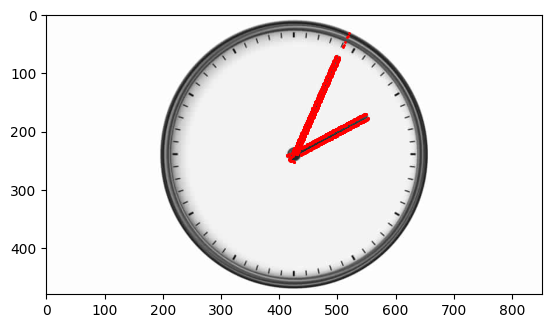

In [ ]:
  print("Time:")
  if (minutes < 10):
    out = str(hours)+":0"+str(minutes)
  else:
    out = str(hours)+":"+str(minutes)
  print(out)
  plt.imshow(im0in, cmap='gray')
  for l in close_c:
    #print("num of points:",len(line))
    for pt in l:
      plt.plot(pt[0], pt[1], marker='o', markersize=1, c="red")
  plt.show()